<a href="https://colab.research.google.com/github/spacewal/-RFM-Recency-Frequency-Monetary-Analysis./blob/main/Module_1_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Conducting RFM Analysis with Your Chosen Dataset

In [ ]:
!pip install lifetimes

In [75]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Loading the Data

In [92]:
df = pd.read_csv('https://raw.githubusercontent.com/spacewal/-RFM-Recency-Frequency-Monetary-Analysis./main/scanner_data.csv')

# Data Cleaning and Preparation

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


In [94]:
df.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [95]:
df.rename(columns={'Unnamed: 0': 'Row ID'}, inplace=True)

In [99]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Row ID          131706 non-null  int64         
 1   Date            131706 non-null  datetime64[ns]
 2   Customer_ID     131706 non-null  int64         
 3   Transaction_ID  131706 non-null  int64         
 4   SKU_Category    131706 non-null  object        
 5   SKU             131706 non-null  object        
 6   Quantity        131706 non-null  float64       
 7   Sales_Amount    131706 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 8.0+ MB


# RFM Analysis
## Ensure the proper columns are present:

In [101]:
# Ensure the necessary columns are present and correct
if 'Quantity' in df.columns and 'Sales_Amount' in df.columns:
    # Create a 'Total' column representing total spending per transaction
    df['Total'] = df['Quantity'] * df['Sales_Amount']
else:
    raise KeyError("Required columns 'Quantity' and 'Sales_Amount' are missing")

In [102]:
df.columns

Index(['Row ID', 'Date', 'Customer_ID', 'Transaction_ID', 'SKU_Category', 'SKU', 'Quantity', 'Sales_Amount', 'Total'], dtype='object')

# Calculate RFM metrics:

In [103]:
# Recency
latest_date = df['Date'].max() + dt.timedelta(days=1)
rfm = df.groupby('Customer_ID').agg({
    'Date': lambda x: (latest_date - x.max()).days,
    'Transaction_ID': 'count',
    'Total': 'sum'}).reset_index()

rfm.rename(columns={'Date': 'Recency',
                    'Transaction_ID': 'Frequency',
                    'Total': 'MonetaryValue'}, inplace=True)

# Data Visualization
## Visualize the distribution of RFM metrics:

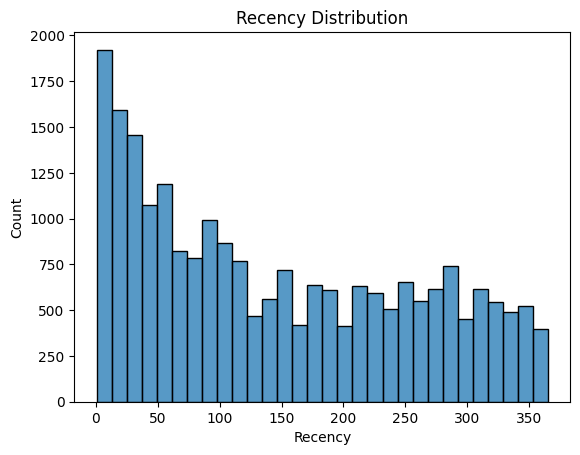

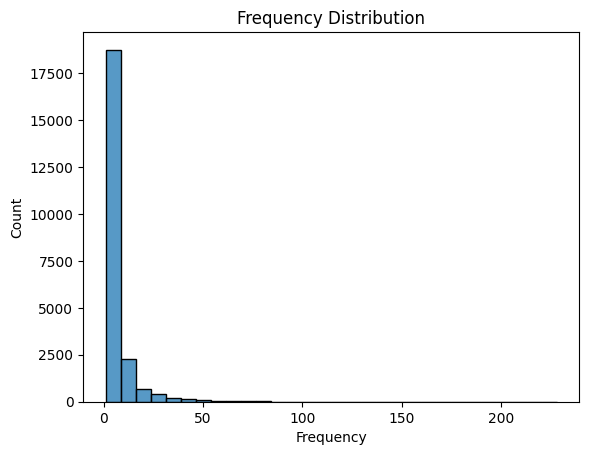

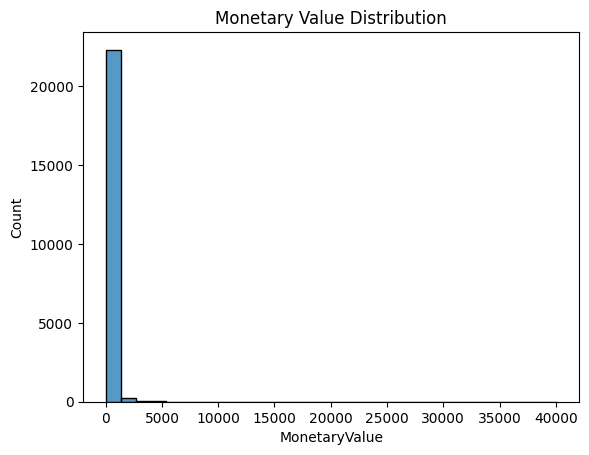

In [104]:
# Recency distribution
sns.histplot(data=rfm, x='Recency', bins=30)
plt.title('Recency Distribution')
plt.show()

# Frequency distribution
sns.histplot(data=rfm, x='Frequency', bins=30)
plt.title('Frequency Distribution')
plt.show()

# Monetary distribution
sns.histplot(data=rfm, x='MonetaryValue', bins=30)
plt.title('Monetary Value Distribution')
plt.show()

# Customer Segmentation
## Apply K-means clustering for customer segmentation:

In [105]:
# Standardizing the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'MonetaryValue']])

# K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)
rfm['Cluster'] = kmeans.labels_

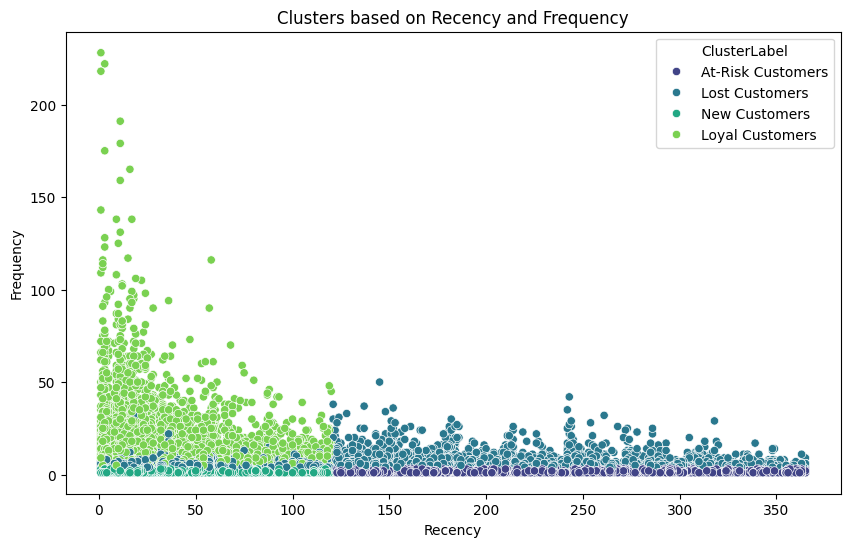

In [108]:
# Example thresholds - adjust these based on your specific data
recency_threshold = 121  # days
frequency_threshold = 3  # number of transactions
monetary_threshold = 85  # monetary value

# Determine the nature of each cluster
cluster_labels = []
for index, row in rfm.iterrows():
    if row['Recency'] < recency_threshold and row['Frequency'] > frequency_threshold and row['MonetaryValue'] > monetary_threshold:
        cluster_labels.append('Loyal Customers')
    elif row['Recency'] < recency_threshold and row['Frequency'] <= frequency_threshold:
        cluster_labels.append('New Customers')
    elif row['Recency'] >= recency_threshold and row['Frequency'] <= frequency_threshold:
        cluster_labels.append('At-Risk Customers')
    else:
        cluster_labels.append('Lost Customers')

# Map cluster labels to the original DataFrame
rfm['ClusterLabel'] = cluster_labels

# Visualization with Cluster Labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='ClusterLabel', data=rfm, palette='viridis')
plt.title('Clusters based on Recency and Frequency')
plt.show()

Percentiles for RFM metrics:
Recency: 25th percentile = 45.0, 50th percentile = 121.0, 75th percentile = 243.0
Frequency: 25th percentile = 1.0, 50th percentile = 3.0, 75th percentile = 6.0
MonetaryValue: 25th percentile = 10.81, 50th percentile = 27.26, 75th percentile = 83.08


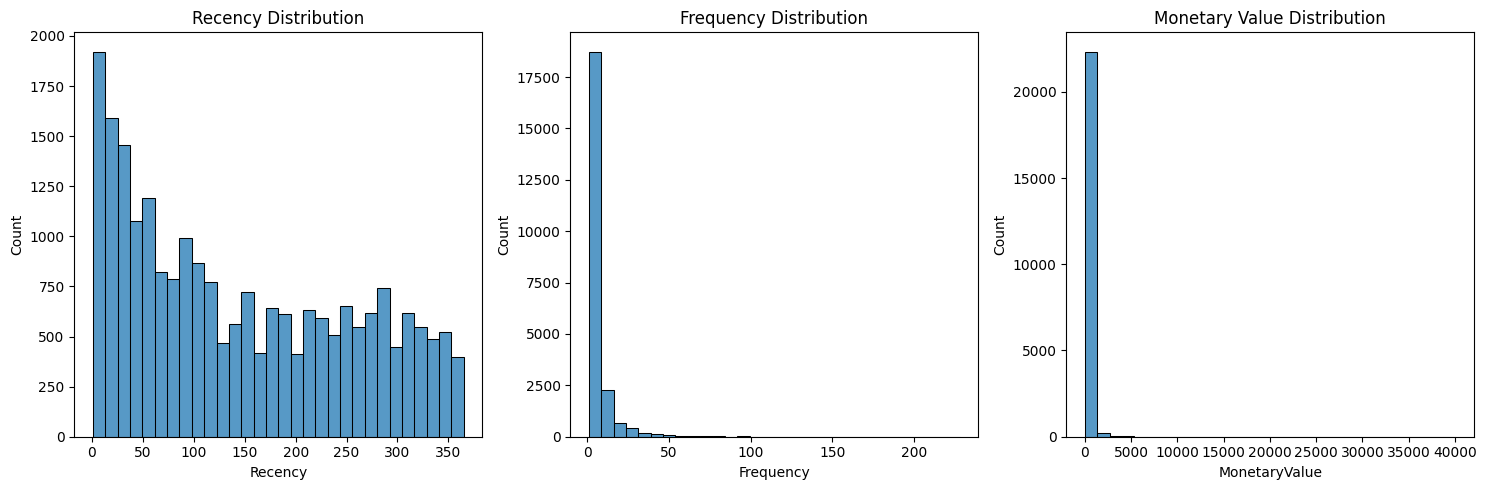

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate percentiles for Recency, Frequency, and MonetaryValue
percentiles = rfm[['Recency', 'Frequency', 'MonetaryValue']].quantile([0.25, 0.5, 0.75]).to_dict()

# Print the percentiles
print("Percentiles for RFM metrics:")
for metric, values in percentiles.items():
    print(f"{metric}: 25th percentile = {values[0.25]}, 50th percentile = {values[0.5]}, 75th percentile = {values[0.75]}")

# Visualize the distribution of Recency, Frequency, and MonetaryValue
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm['MonetaryValue'], bins=30)
plt.title('Monetary Value Distribution')

plt.tight_layout()
plt.show()
